# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import model
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')
                          
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	#torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformer.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training 
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


[INFO] EPOCH: 1/100
Train loss: 2.831437, Test loss: 2.8129, Train IoU: 0.2084, Test IoU: 0.2063, Train Dice: 0.2977, Test Dice: 0.3395
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 2/100
Train loss: 2.793078, Test loss: 2.7839, Train IoU: 0.2224, Test IoU: 0.2254, Train Dice: 0.3568, Test Dice: 0.3488
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 3/100
Train loss: 2.761087, Test loss: 2.7668, Train IoU: 0.2431, Test IoU: 0.2418, Train Dice: 0.3798, Test Dice: 0.3777
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 4/100
Train loss: 2.737859, Test loss: 2.7259, Train IoU: 0.2685, Test IoU: 0.2806, Train Dice: 0.4038, Test Dice: 0.4107
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 5/100
Train loss: 2.658757, Test loss: 2.6570, Train IoU: 0.3371, Test IoU: 0.3364, Train Dice: 0.4896, Test Dice: 0.4998
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 6/100
Train loss: 2.600848, Test loss: 2.5704, Train IoU: 0.3900, Test IoU: 0.4201, Train Dice: 0.5576, Test Dice: 0.5881
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 7/100
Train loss: 2.543907, Test loss: 2.5319, Train IoU: 0.4484, Test IoU: 0.4615, Train Dice: 0.6138, Test Dice: 0.6252
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 8/100
Train loss: 2.501131, Test loss: 2.4830, Train IoU: 0.4953, Test IoU: 0.5172, Train Dice: 0.6565, Test Dice: 0.6745
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 9/100
Train loss: 2.472083, Test loss: 2.4845, Train IoU: 0.5288, Test IoU: 0.5140, Train Dice: 0.6857, Test Dice: 0.6738


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 10/100
Train loss: 2.462497, Test loss: 2.4541, Train IoU: 0.5398, Test IoU: 0.5498, Train Dice: 0.6961, Test Dice: 0.7046
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 11/100
Train loss: 2.454077, Test loss: 2.4393, Train IoU: 0.5494, Test IoU: 0.5675, Train Dice: 0.7041, Test Dice: 0.7206
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 12/100
Train loss: 2.431913, Test loss: 2.4233, Train IoU: 0.5773, Test IoU: 0.5880, Train Dice: 0.7265, Test Dice: 0.7365
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 13/100
Train loss: 2.408186, Test loss: 2.4005, Train IoU: 0.6081, Test IoU: 0.6190, Train Dice: 0.7506, Test Dice: 0.7572
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 14/100
Train loss: 2.389627, Test loss: 2.3900, Train IoU: 0.6327, Test IoU: 0.6329, Train Dice: 0.7689, Test Dice: 0.7689
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 15/100
Train loss: 2.383172, Test loss: 2.3889, Train IoU: 0.6413, Test IoU: 0.6337, Train Dice: 0.7758, Test Dice: 0.7701
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 16/100
Train loss: 2.376810, Test loss: 2.3744, Train IoU: 0.6501, Test IoU: 0.6541, Train Dice: 0.7825, Test Dice: 0.7845
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 17/100
Train loss: 2.360540, Test loss: 2.3617, Train IoU: 0.6735, Test IoU: 0.6710, Train Dice: 0.7988, Test Dice: 0.7988
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 18/100
Train loss: 2.348908, Test loss: 2.3802, Train IoU: 0.6896, Test IoU: 0.6459, Train Dice: 0.8109, Test Dice: 0.7796


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 19/100
Train loss: 2.347184, Test loss: 2.3683, Train IoU: 0.6918, Test IoU: 0.6610, Train Dice: 0.8128, Test Dice: 0.7922


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 20/100
Train loss: 2.337162, Test loss: 2.3446, Train IoU: 0.7063, Test IoU: 0.6952, Train Dice: 0.8231, Test Dice: 0.8160
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 21/100
Train loss: 2.323097, Test loss: 2.3369, Train IoU: 0.7270, Test IoU: 0.7069, Train Dice: 0.8376, Test Dice: 0.8240
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 22/100
Train loss: 2.318988, Test loss: 2.3476, Train IoU: 0.7330, Test IoU: 0.6909, Train Dice: 0.8418, Test Dice: 0.8131


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 23/100
Train loss: 2.326112, Test loss: 2.3424, Train IoU: 0.7226, Test IoU: 0.6974, Train Dice: 0.8348, Test Dice: 0.8186


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 24/100
Train loss: 2.319477, Test loss: 2.3336, Train IoU: 0.7320, Test IoU: 0.7106, Train Dice: 0.8417, Test Dice: 0.8275
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 25/100
Train loss: 2.308089, Test loss: 2.3297, Train IoU: 0.7498, Test IoU: 0.7169, Train Dice: 0.8532, Test Dice: 0.8314
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 26/100
Train loss: 2.296727, Test loss: 2.3213, Train IoU: 0.7670, Test IoU: 0.7297, Train Dice: 0.8648, Test Dice: 0.8401
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 27/100
Train loss: 2.291353, Test loss: 2.3179, Train IoU: 0.7758, Test IoU: 0.7340, Train Dice: 0.8703, Test Dice: 0.8436
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 28/100
Train loss: 2.286334, Test loss: 2.3046, Train IoU: 0.7840, Test IoU: 0.7545, Train Dice: 0.8754, Test Dice: 0.8570
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 29/100
Train loss: 2.284325, Test loss: 2.3077, Train IoU: 0.7872, Test IoU: 0.7500, Train Dice: 0.8774, Test Dice: 0.8540


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 30/100
Train loss: 2.281478, Test loss: 2.3005, Train IoU: 0.7913, Test IoU: 0.7608, Train Dice: 0.8805, Test Dice: 0.8613
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 31/100
Train loss: 2.275135, Test loss: 2.3043, Train IoU: 0.8016, Test IoU: 0.7551, Train Dice: 0.8870, Test Dice: 0.8575


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 32/100
Train loss: 2.277631, Test loss: 2.3026, Train IoU: 0.7975, Test IoU: 0.7575, Train Dice: 0.8844, Test Dice: 0.8595


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 33/100
Train loss: 2.271238, Test loss: 2.2960, Train IoU: 0.8080, Test IoU: 0.7679, Train Dice: 0.8910, Test Dice: 0.8660
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 34/100
Train loss: 2.270018, Test loss: 2.3002, Train IoU: 0.8103, Test IoU: 0.7614, Train Dice: 0.8922, Test Dice: 0.8620


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 35/100
Train loss: 2.265135, Test loss: 2.2940, Train IoU: 0.8183, Test IoU: 0.7712, Train Dice: 0.8972, Test Dice: 0.8682
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 36/100
Train loss: 2.259665, Test loss: 2.2871, Train IoU: 0.8274, Test IoU: 0.7821, Train Dice: 0.9028, Test Dice: 0.8752
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 37/100
Train loss: 2.257740, Test loss: 2.2865, Train IoU: 0.8305, Test IoU: 0.7830, Train Dice: 0.9048, Test Dice: 0.8759
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 38/100
Train loss: 2.259459, Test loss: 2.2853, Train IoU: 0.8277, Test IoU: 0.7849, Train Dice: 0.9030, Test Dice: 0.8771
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 39/100
Train loss: 2.257784, Test loss: 2.2874, Train IoU: 0.8304, Test IoU: 0.7815, Train Dice: 0.9049, Test Dice: 0.8751


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 40/100
Train loss: 2.265452, Test loss: 2.2978, Train IoU: 0.8174, Test IoU: 0.7649, Train Dice: 0.8971, Test Dice: 0.8646


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 41/100
Train loss: 2.263919, Test loss: 2.2878, Train IoU: 0.8196, Test IoU: 0.7810, Train Dice: 0.8987, Test Dice: 0.8748


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 42/100
Train loss: 2.259556, Test loss: 2.2855, Train IoU: 0.8269, Test IoU: 0.7846, Train Dice: 0.9033, Test Dice: 0.8771


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 43/100
Train loss: 2.256174, Test loss: 2.2821, Train IoU: 0.8327, Test IoU: 0.7901, Train Dice: 0.9067, Test Dice: 0.8806
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 44/100
Train loss: 2.254362, Test loss: 2.2837, Train IoU: 0.8357, Test IoU: 0.7873, Train Dice: 0.9085, Test Dice: 0.8790


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 45/100
Train loss: 2.251585, Test loss: 2.2769, Train IoU: 0.8407, Test IoU: 0.7981, Train Dice: 0.9113, Test Dice: 0.8858
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 46/100
Train loss: 2.246610, Test loss: 2.2776, Train IoU: 0.8492, Test IoU: 0.7972, Train Dice: 0.9164, Test Dice: 0.8852


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 47/100
Train loss: 2.245723, Test loss: 2.2758, Train IoU: 0.8507, Test IoU: 0.8004, Train Dice: 0.9173, Test Dice: 0.8869
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 48/100
Train loss: 2.249455, Test loss: 2.2814, Train IoU: 0.8441, Test IoU: 0.7907, Train Dice: 0.9135, Test Dice: 0.8814


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 49/100
Train loss: 2.246142, Test loss: 2.2801, Train IoU: 0.8501, Test IoU: 0.7932, Train Dice: 0.9169, Test Dice: 0.8828


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 50/100
Train loss: 2.244060, Test loss: 2.2749, Train IoU: 0.8536, Test IoU: 0.8015, Train Dice: 0.9190, Test Dice: 0.8880
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 51/100
Train loss: 2.244219, Test loss: 2.2742, Train IoU: 0.8532, Test IoU: 0.8026, Train Dice: 0.9190, Test Dice: 0.8888
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 52/100
Train loss: 2.241483, Test loss: 2.2720, Train IoU: 0.8579, Test IoU: 0.8063, Train Dice: 0.9217, Test Dice: 0.8910
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 53/100
Train loss: 2.242119, Test loss: 2.2738, Train IoU: 0.8568, Test IoU: 0.8035, Train Dice: 0.9211, Test Dice: 0.8893


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 54/100
Train loss: 2.238770, Test loss: 2.2685, Train IoU: 0.8628, Test IoU: 0.8122, Train Dice: 0.9245, Test Dice: 0.8946
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 55/100
Train loss: 2.237143, Test loss: 2.2697, Train IoU: 0.8656, Test IoU: 0.8101, Train Dice: 0.9262, Test Dice: 0.8934


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 56/100
Train loss: 2.237504, Test loss: 2.2720, Train IoU: 0.8648, Test IoU: 0.8063, Train Dice: 0.9258, Test Dice: 0.8911


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 57/100
Train loss: 2.236511, Test loss: 2.2744, Train IoU: 0.8668, Test IoU: 0.8024, Train Dice: 0.9268, Test Dice: 0.8888


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 58/100
Train loss: 2.235551, Test loss: 2.2723, Train IoU: 0.8683, Test IoU: 0.8059, Train Dice: 0.9278, Test Dice: 0.8909


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 59/100
Train loss: 2.234168, Test loss: 2.2713, Train IoU: 0.8709, Test IoU: 0.8071, Train Dice: 0.9292, Test Dice: 0.8918


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 60/100
Train loss: 2.236198, Test loss: 2.2709, Train IoU: 0.8672, Test IoU: 0.8079, Train Dice: 0.9272, Test Dice: 0.8924


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 61/100
Train loss: 2.235260, Test loss: 2.2704, Train IoU: 0.8688, Test IoU: 0.8092, Train Dice: 0.9282, Test Dice: 0.8929


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 62/100
Train loss: 2.233836, Test loss: 2.2724, Train IoU: 0.8714, Test IoU: 0.8054, Train Dice: 0.9296, Test Dice: 0.8909


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 63/100
Train loss: 2.236716, Test loss: 2.2741, Train IoU: 0.8661, Test IoU: 0.8026, Train Dice: 0.9267, Test Dice: 0.8891


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 64/100
Train loss: 2.236140, Test loss: 2.2703, Train IoU: 0.8672, Test IoU: 0.8090, Train Dice: 0.9273, Test Dice: 0.8930


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 65/100
Train loss: 2.236343, Test loss: 2.2715, Train IoU: 0.8668, Test IoU: 0.8071, Train Dice: 0.9271, Test Dice: 0.8918


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 66/100
Train loss: 2.235323, Test loss: 2.2701, Train IoU: 0.8685, Test IoU: 0.8096, Train Dice: 0.9282, Test Dice: 0.8933


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 67/100
Train loss: 2.234732, Test loss: 2.2670, Train IoU: 0.8699, Test IoU: 0.8143, Train Dice: 0.9288, Test Dice: 0.8963
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 68/100
Train loss: 2.232016, Test loss: 2.2701, Train IoU: 0.8745, Test IoU: 0.8091, Train Dice: 0.9315, Test Dice: 0.8933


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 69/100
Train loss: 2.232954, Test loss: 2.2701, Train IoU: 0.8727, Test IoU: 0.8090, Train Dice: 0.9306, Test Dice: 0.8933


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 70/100
Train loss: 2.231572, Test loss: 2.2650, Train IoU: 0.8752, Test IoU: 0.8177, Train Dice: 0.9320, Test Dice: 0.8984
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 71/100
Train loss: 2.231342, Test loss: 2.2666, Train IoU: 0.8754, Test IoU: 0.8149, Train Dice: 0.9323, Test Dice: 0.8967


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 72/100
Train loss: 2.230619, Test loss: 2.2664, Train IoU: 0.8769, Test IoU: 0.8154, Train Dice: 0.9330, Test Dice: 0.8970


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 73/100
Train loss: 2.230230, Test loss: 2.2683, Train IoU: 0.8775, Test IoU: 0.8121, Train Dice: 0.9334, Test Dice: 0.8951


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 74/100
Train loss: 2.229964, Test loss: 2.2674, Train IoU: 0.8781, Test IoU: 0.8137, Train Dice: 0.9337, Test Dice: 0.8961


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 75/100
Train loss: 2.230413, Test loss: 2.2655, Train IoU: 0.8773, Test IoU: 0.8167, Train Dice: 0.9332, Test Dice: 0.8980


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 76/100
Train loss: 2.234260, Test loss: 2.2685, Train IoU: 0.8703, Test IoU: 0.8119, Train Dice: 0.9294, Test Dice: 0.8949


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 77/100
Train loss: 2.234659, Test loss: 2.2728, Train IoU: 0.8694, Test IoU: 0.8048, Train Dice: 0.9290, Test Dice: 0.8907


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 78/100
Train loss: 2.238060, Test loss: 2.2741, Train IoU: 0.8635, Test IoU: 0.8028, Train Dice: 0.9256, Test Dice: 0.8893


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 79/100
Train loss: 2.237890, Test loss: 2.2734, Train IoU: 0.8639, Test IoU: 0.8037, Train Dice: 0.9257, Test Dice: 0.8900


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 80/100
Train loss: 2.236053, Test loss: 2.2681, Train IoU: 0.8671, Test IoU: 0.8127, Train Dice: 0.9276, Test Dice: 0.8954


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 81/100
Train loss: 2.231298, Test loss: 2.2629, Train IoU: 0.8753, Test IoU: 0.8214, Train Dice: 0.9324, Test Dice: 0.9006
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 82/100
Train loss: 2.230308, Test loss: 2.2646, Train IoU: 0.8773, Test IoU: 0.8183, Train Dice: 0.9334, Test Dice: 0.8990


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 83/100
Train loss: 2.228785, Test loss: 2.2644, Train IoU: 0.8799, Test IoU: 0.8186, Train Dice: 0.9349, Test Dice: 0.8991


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 84/100
Train loss: 2.230009, Test loss: 2.2620, Train IoU: 0.8778, Test IoU: 0.8226, Train Dice: 0.9337, Test Dice: 0.9016
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 85/100
Train loss: 2.231210, Test loss: 2.2690, Train IoU: 0.8755, Test IoU: 0.8112, Train Dice: 0.9325, Test Dice: 0.8946


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 86/100
Train loss: 2.229411, Test loss: 2.2636, Train IoU: 0.8789, Test IoU: 0.8198, Train Dice: 0.9344, Test Dice: 0.8999


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 87/100
Train loss: 2.227682, Test loss: 2.2649, Train IoU: 0.8819, Test IoU: 0.8180, Train Dice: 0.9361, Test Dice: 0.8987


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 88/100
Train loss: 2.227311, Test loss: 2.2677, Train IoU: 0.8827, Test IoU: 0.8130, Train Dice: 0.9365, Test Dice: 0.8959


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 89/100
Train loss: 2.230489, Test loss: 2.2665, Train IoU: 0.8768, Test IoU: 0.8150, Train Dice: 0.9333, Test Dice: 0.8971


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 90/100
Train loss: 2.229160, Test loss: 2.2621, Train IoU: 0.8794, Test IoU: 0.8223, Train Dice: 0.9346, Test Dice: 0.9015


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 91/100
Train loss: 2.226230, Test loss: 2.2648, Train IoU: 0.8847, Test IoU: 0.8180, Train Dice: 0.9376, Test Dice: 0.8988


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 92/100
Train loss: 2.227836, Test loss: 2.2649, Train IoU: 0.8817, Test IoU: 0.8177, Train Dice: 0.9360, Test Dice: 0.8987


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 93/100
Train loss: 2.228134, Test loss: 2.2641, Train IoU: 0.8811, Test IoU: 0.8190, Train Dice: 0.9357, Test Dice: 0.8996


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 94/100
Train loss: 2.226387, Test loss: 2.2621, Train IoU: 0.8842, Test IoU: 0.8223, Train Dice: 0.9375, Test Dice: 0.9015


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 95/100
Train loss: 2.224620, Test loss: 2.2621, Train IoU: 0.8876, Test IoU: 0.8222, Train Dice: 0.9392, Test Dice: 0.9015


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


[INFO] EPOCH: 96/100
Train loss: 2.226491, Test loss: 2.2618, Train IoU: 0.8840, Test IoU: 0.8229, Train Dice: 0.9373, Test Dice: 0.9018
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 97/100
Train loss: 2.227767, Test loss: 2.2640, Train IoU: 0.8817, Test IoU: 0.8191, Train Dice: 0.9361, Test Dice: 0.8997


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 98/100
Train loss: 2.227350, Test loss: 2.2613, Train IoU: 0.8824, Test IoU: 0.8235, Train Dice: 0.9365, Test Dice: 0.9023
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 99/100
Train loss: 2.226545, Test loss: 2.2636, Train IoU: 0.8839, Test IoU: 0.8200, Train Dice: 0.9373, Test Dice: 0.9000


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 100/100
Train loss: 2.225846, Test loss: 2.2618, Train IoU: 0.8852, Test IoU: 0.8231, Train Dice: 0.9380, Test Dice: 0.9019
[INFO] total time taken to train the model: 624.96s
Best IoU is: 0.82353


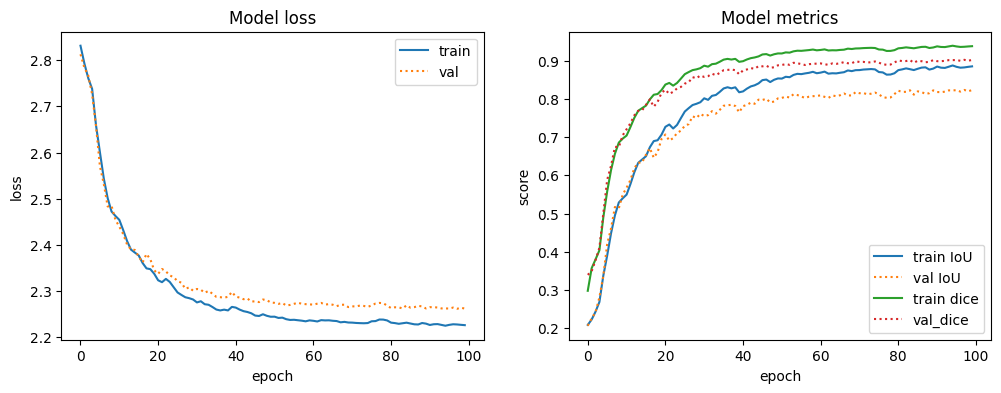

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

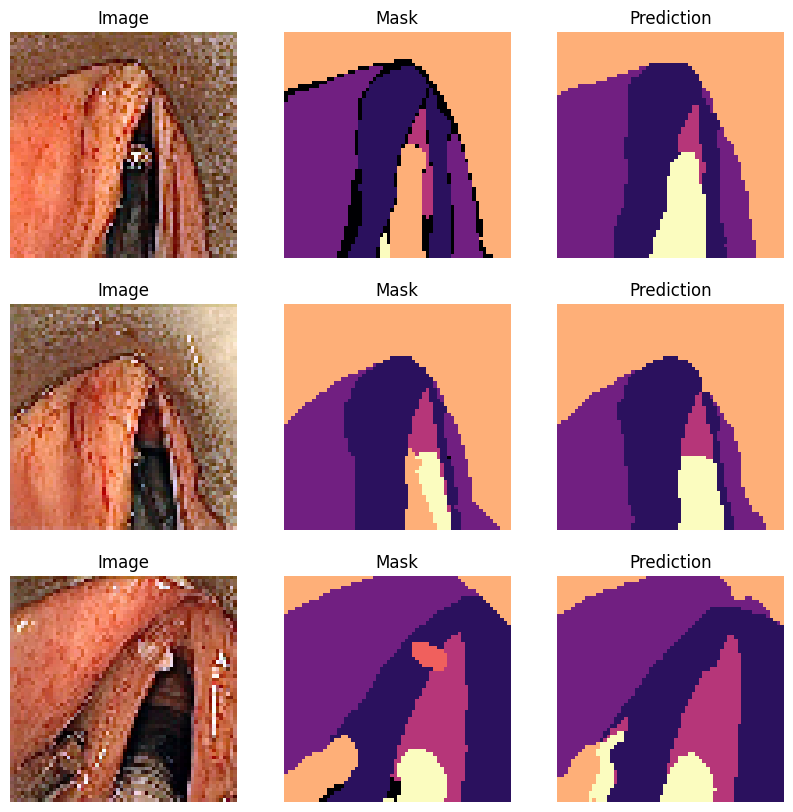

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota